In [ ]:
!conda install /kaggle/input/how-to-use-pyvips-offline/*.tar.bz2


In [3]:
import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyvips

import cv2
import PIL

import random
import tensorflow as tf
#print("TensorFlow version:", tf.__version__)

from pathlib import Path
from glob import glob
from random import randrange

from collections import defaultdict
from openslide import OpenSlide

from tensorflow.keras import layers, models, Model, Input
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from skimage.exposure import is_low_contrast
from collections import defaultdict
from skimage.io import imread
from PIL import Image
from pathlib import Path
from tqdm import tqdm

random.seed(19)
tf.random.set_seed(19)

In [4]:
IMG_SIZE = 224
IMG_CHANNELS = 3

In [5]:
data_path ='../input/mayo-clinic-strip-ai/'
test_path = data_path + 'test/'

In [6]:
test_csv_data = pd.read_csv(data_path + 'test.csv')

In [7]:
test_images_mtdt = glob(test_path + "*")
print(f"Number of images in a testing set: {len(test_images_mtdt)}")

Number of images in a testing set: 4


In [8]:
def get_images_info(images_mtdt, label_df):
    img_prop = defaultdict(list)
    for i, path in enumerate(images_mtdt):
        img_path = images_mtdt[i]
        image_id = img_path[-12:-4]

        slide = OpenSlide(img_path)

        big_dim = 'none'
        max_min_dim_ratio = 1.0

        img_width = slide.dimensions[0]
        img_height = slide.dimensions[1]

        if(img_width > img_height):
            big_dim = 'width'
            max_min_dim_ratio = round(img_width/img_height, 2)
        elif(img_width < img_height):
            big_dim = 'height'
            max_min_dim_ratio = round(img_height/img_width, 2)

        img_prop['image_id'].append(image_id)
        img_prop['width'].append(img_width)
        img_prop['height'].append(img_height)
        img_prop['big_dim'].append(big_dim)
        img_prop['max_min_dim_ratio'].append(max_min_dim_ratio)
        
        split_size = round(max_min_dim_ratio)
        img_prop['split_size'].append(split_size)
        img_prop['path'].append(img_path)
        
        img_info = pd.DataFrame(img_prop)
        img_info.sort_values(by='image_id', inplace=True)
        img_info.reset_index(inplace=True, drop=True)
        img_info = img_info.merge(label_df, on='image_id')

    return img_info

In [9]:
test_images_info = get_images_info(test_images_mtdt, test_csv_data)
test_images_count = test_images_info['image_id'].nunique()
test_images = np.zeros((test_images_count, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

In [10]:
# function to check if the image contains useful information after the crop.
def get_score(img):
    imgray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(hierarchy[0]), len(contours))
    return len(contours)

In [11]:
def process_tiles(row, last_img_index, score_dict):
    image_id = row['image_id']
    
    width = row['width']
    height = row['height']
    big_dim = row['big_dim']
    split_size = row['split_size']
    input_test_path = row['path']
    center_id = row['center_id']
    patient_id = row['patient_id']
    image_num = row['image_num']
    #label = row['label']
    
    n_across = 1
    n_down = 1

    if(split_size == 1):
        crop_width = width
        crop_height = height
    if(big_dim == 'width'):
        crop_width = width//split_size
        crop_height = height
        n_across = split_size
    else:
        crop_height = height//split_size
        crop_width = width
        n_down = split_size

    selected_tile = None
    max_tile_score = 0

    vips_img = pyvips.Image.new_from_file(input_test_path, access='sequential')

    for x in range(n_across):
        for y in range(n_down):
            vips_tile = None
            if(split_size > 1):
                vips_tile = vips_img.crop(x*crop_width, y*crop_height, crop_width, crop_height)
            else:
                vips_tile = vips_img
                
            vips_tile = vips_tile.thumbnail_image(IMG_SIZE, height=IMG_SIZE, size='force')
            tile_score = get_score(vips_tile)
            print('processing slice: ', (x+y) , crop_width, ' X ', crop_height, 'score', tile_score)
            
            if(tile_score > max_tile_score):
                max_tile_score = tile_score
                selected_tile = vips_tile
    
    test_image = selected_tile.numpy()
    test_images[last_img_index] = test_image
    score_dict['last_img_index'].append(last_img_index)
    score_dict['patient_id'].append(patient_id)
    score_dict['score'].append(max_tile_score)
    last_img_index += 1
    
    vips_img = None
    return last_img_index

In [12]:
def generate_tiles():
    score_dict = defaultdict(list)
    last_img_index = 0
    #change to test_images_info
    for ind, row in test_images_info.iterrows():
#         if(ind > 280):
#             continue
        print('processing image:', row['image_id'], 'index:', str(ind + 1))
        last_img_index = process_tiles(row, last_img_index, score_dict)
        print('====================================')
    print('processed test images:', last_img_index)
    return pd.DataFrame(score_dict)

In [13]:
score_df = generate_tiles()

processing image: 006388_0 index: 1
processing slice:  0 34007  X  30398 score 132
processing slice:  1 34007  X  30398 score 181
processing image: 008e5c_0 index: 2
processing slice:  0 5946  X  5938 score 515
processing slice:  1 5946  X  5938 score 45
processing slice:  2 5946  X  5938 score 1
processing slice:  3 5946  X  5938 score 49
processing slice:  4 5946  X  5938 score 475
processing image: 00c058_0 index: 3
processing slice:  0 15255  X  15450 score 217
processing slice:  1 15255  X  15450 score 31
processing slice:  2 15255  X  15450 score 21
processing slice:  3 15255  X  15450 score 159
processing image: 01adc5_0 index: 4
processing slice:  0 27915  X  26553 score 98
processing slice:  1 27915  X  26553 score 128
processed test images: 4


In [14]:
score_df.head()

,last_img_index,patient_id,score
0,0,006388,181
1,1,008e5c,515
2,2,00c058,217
3,3,01adc5,128


In [15]:
len(score_df)

4

In [17]:
def show(image):
    print(image.shape)
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

(224, 224, 3)


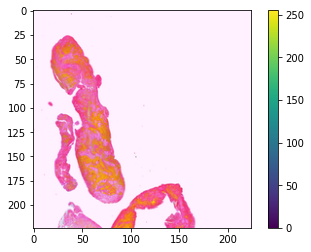

In [18]:
index = 2
show(test_images[index])

In [19]:
len(test_images)

4

In [21]:
os.listdir('../input/training-mayo-clinic/')

['inception1.h5',
 '__results__.html',
 '__notebook__.ipynb',
 '__results___files',
 '__output__.json',
 'custom.css']

In [22]:
new_model = models.load_model('../input/training-mayo-clinic/inception1.h5')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
test_images = test_images/255.0

In [24]:
test_images_tensor = tf.convert_to_tensor(test_images)
result = new_model.predict(test_images_tensor)
result = tf.nn.softmax(result)
result = np.round(result, 6)
result

array([[0.605432, 0.394568],
       [0.730884, 0.269116],
       [0.554684, 0.445316],
       [0.582602, 0.417398]], dtype=float32)

In [25]:
submission_df = pd.DataFrame(result, columns=['CE', 'LAA'])
submission_df.insert(0, 'patient_id', score_df['patient_id'])

In [26]:
def maxprediction(data_frame):
    data_frame = data_frame.assign(prob_diff = abs(data_frame['CE'] - data_frame['LAA']))
    max_diff = data_frame.loc[data_frame['prob_diff'].idxmax()]
    
    return  max_diff[['CE', 'LAA']]

In [27]:
submission_df = submission_df[['patient_id','CE', 'LAA']].groupby(['patient_id']).apply(maxprediction).reset_index()

In [28]:
submission_df.to_csv('submission.csv', index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.605432,0.394568
008e5c,0.730884,0.269116
00c058,0.554684,0.445316
01adc5,0.582602,0.417398


In [29]:
os.listdir()

['submission.csv', '.virtual_documents']